# Plot comparison between $M_0$ and $T_{hold}$

Plot the comparison to evaluate the time healing of the friction on the gouge patch.

2025.01.05 Kurama Okubo

- 2025.01.28 update with the error bar

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib import ticker

%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
import copy

import scipy.io as sio
from scipy.signal import decimate

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False #True


In [2]:
# datadir = "../data/M0vsStressDrop/"
# if not os.path.exists(datadir):
#     os.makedirs(datadir)

figdir = "../figure/M0vsStressDrop/"
if not os.path.exists(figdir):
    os.makedirs(figdir)


In [3]:
expr_id = 87

# Load stress drop data

In [4]:
fi_stressdrop = f"../../../Experiments/DetectEvent/data/Macroscopic_stats_FB03_{expr_id:03d}.csv"

In [5]:
df_stressdrop = pd.read_csv(fi_stressdrop, index_col=0)
df_stressdrop.head()

,event_starttime[s],nucleation_loc,rupture_velocity[m/s],macroshearstress_beforeevent[MPa],macroshearstress_afterevent[MPa],macroshearstress_drop[MPa],slip_mean[mm],slip_std[mm]
stickslip_eventID,,,,,,,,
1,36.645495,B,NaN,0.687261,0.632096,0.055165,0.095133,0.003417
2,40.942166,W,26.300284,0.646850,0.628809,0.018041,0.032737,0.000485
3,42.420369,E,161.832114,0.644769,0.627316,0.017453,0.032203,0.001678
4,43.575068,E,99.132755,0.643216,0.628802,0.014413,0.029163,0.001416
5,47.621651,E,231.696733,0.653045,0.628926,0.024119,0.040945,0.001128


# Load gouge event catalog

In [6]:
# read gouge event catalog
gougepatch_id = "G3"
Qinv_quart = 50

Nvalidsensors_thresh = 4

finame = f"../../../GougeEventCatalog/data/gougeeventcatalog__fb03-{expr_id:03d}__{gougepatch_id}__Q{Qinv_quart}.csv"
df_gc = pd.read_csv(finame, index_col=0)
df_gc_selected = df_gc[df_gc["Nvalidsensors"] >= Nvalidsensors_thresh].copy()
df_gc_selected.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


# Link the gouge event and stress drop

In [7]:
for eid, row in df_gc_selected.iterrows():
    stickslip_id = row.stickslip_id
    df_gc_selected.loc[eid, "Shearstress_before"] = df_stressdrop.loc[stickslip_id, "macroshearstress_beforeevent[MPa]"]
    df_gc_selected.loc[eid, "Shearstress_after"] = df_stressdrop.loc[stickslip_id, "macroshearstress_afterevent[MPa]"]
    df_gc_selected.loc[eid, "Stressdrop"] = df_stressdrop.loc[stickslip_id, "macroshearstress_drop[MPa]"]
    df_gc_selected.loc[eid, "Slip_mean"] = df_stressdrop.loc[stickslip_id, "slip_mean[mm]"]

df_gc_selected.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std,Shearstress_before,Shearstress_after,Stressdrop,Slip_mean
event_id,,,,,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07,0.644769,0.627316,0.017453,0.032203
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07,0.653045,0.628926,0.024119,0.040945
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07,0.650010,0.632651,0.017358,0.031310
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07,0.650010,0.632645,0.017365,0.031082
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07,0.650010,0.632645,0.017365,0.031082


In [8]:
def M02Mw(M0):
    return (np.log10(M0) - 9.1) * 2.0 / 3.0 # synchronized with OpenSWPC : moment_magnitude ( m0 )

def Mw2M0(Mw):
    return 10**( 1.5 * Mw + 9.05) # synchronized with OpenSWPC : seismic_moment ( mw )
   

In [9]:
scatter_mc = sns.color_palette("Set1")
scatter_mc

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

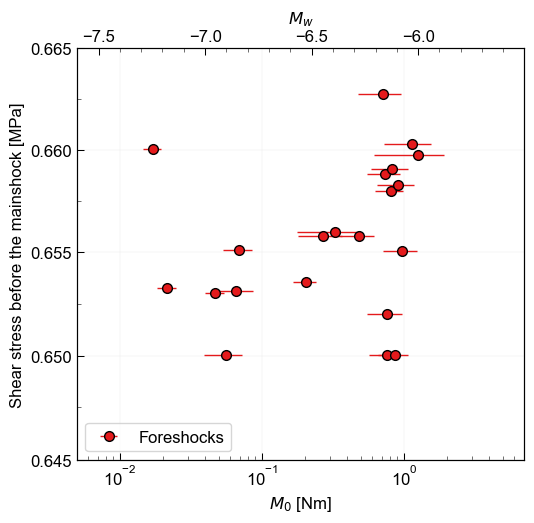

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.4))
mainmarkersize=7

df_gc_fore = df_gc_selected[df_gc_selected["event_label"]=="F"]
# df_gc_fore.plot.scatter(x="Shearstress_before", y="Mw", s=60, ax=ax, color="r", marker="o", edgecolor="k", zorder=3, label="Foreshock")
ax.errorbar(df_gc_fore["M0"].values, df_gc_fore["Shearstress_before"].values, xerr=df_gc_fore["M0_std"].values,
           capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=3)


ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("Shear stress before the mainshock [MPa]")


ax.set_xscale('log')
ax.set_yscale('log')

xlimit_scaling = [5e-3, 7]
ax.set_xlim(xlimit_scaling)
ax.set_ylim([0.645, 0.665])

ax.set_yticks(np.arange(0.645, 0.665, 0.005))
ax.set_yticklabels(np.arange(0.645, 0.665, 0.005))

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

ax.legend(loc=3)


#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

plt.tight_layout()

plt.savefig(figdir+f"/M0vsSSbefore_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.png", format="png", dpi=200)
# plt.savefig(figdir+f"/M0vsSSbefore_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.pdf")


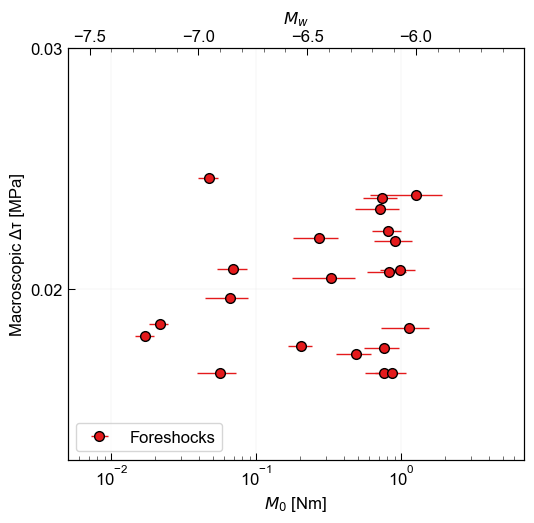

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.4))
mainmarkersize=7

df_gc_fore = df_gc_selected[df_gc_selected["event_label"]=="F"]
# df_gc_fore.plot.scatter(x="Shearstress_before", y="Mw", s=60, ax=ax, color="r", marker="o", edgecolor="k", zorder=3, label="Foreshock")
ax.errorbar(df_gc_fore["M0"].values, df_gc_fore["Stressdrop"].values, xerr=df_gc_fore["M0_std"].values,
           capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=3)


ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("Macroscopic Δτ [MPa]")

ax.set_xscale('log')
ax.set_yscale('log')

xlimit_scaling = [5e-3, 7]
ax.set_xlim(xlimit_scaling)
ax.set_ylim([1.5e-2, 3.0e-2])

ax.set_yticks(np.arange(0.02, 0.04, 0.01))
ax.set_yticklabels(np.arange(0.02, 0.04, 0.01))

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

ax.legend(loc=3)


#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

plt.tight_layout()

plt.savefig(figdir+f"/M0vsStressdrop_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.png", format="png", dpi=200)
# plt.savefig(figdir+f"/M0vsStressdrop_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.pdf")


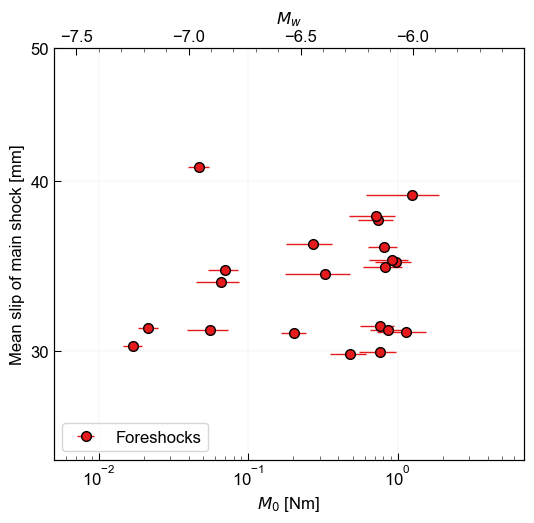

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.4))
mainmarkersize=7

df_gc_fore = df_gc_selected[df_gc_selected["event_label"]=="F"]
# df_gc_fore.plot.scatter(x="Shearstress_before", y="Mw", s=60, ax=ax, color="r", marker="o", edgecolor="k", zorder=3, label="Foreshock")
ax.errorbar(df_gc_fore["M0"].values, df_gc_fore["Slip_mean"].values*1e3, xerr=df_gc_fore["M0_std"].values,
           capsize=0, fmt="o", markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "k", label="Foreshocks", zorder=3)


ax.set_xlabel("$M_0$ [Nm]")
# ax.set_ylabel("Macroscopic Δτ [MPa]")
ax.set_ylabel("Mean slip of main shock [mm]")

ax.set_xscale('log')
ax.set_yscale('log')

xlimit_scaling = [5e-3, 7]
ax.set_xlim(xlimit_scaling)
ax.set_ylim([25, 50])

ax.set_yticks(np.arange(30, 60, 10))
ax.set_yticklabels(np.arange(30, 60, 10))

# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

ax.legend(loc=3)


#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

plt.tight_layout()

plt.savefig(figdir+f"/M0vsMeanSlip_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.png", format="png", dpi=200)
# plt.savefig(figdir+f"/M0vsMeanSlip_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}.pdf")
